## A tutorial to get you started faster
In this tutorial we will show you a breif example about how our model works, you will learn that quickly
<br/>
We will generate a synthetic network(BA with 256 nodes) and try to compress it to a macro(smaller) network with 30 nodes

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import *
import random
import numpy as np

import torch
import torch_geometric

from model import Encoder,WeightSumDecoder
from data import get_feature,standardize_matrix,get_zt
from utils import mins_cross_entropy,shuffle_rows,visualize_weighted_graph

In [2]:
torch.__version__,torch_geometric.__version__,np.__version__

('2.0.1', '2.4.0', '1.26.1')

In [3]:
s = 2050
torch.manual_seed(s)
np.random.seed(s)
random.seed(s)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## get a synthetic network

In [4]:
g = nx.barabasi_albert_graph(256,2)

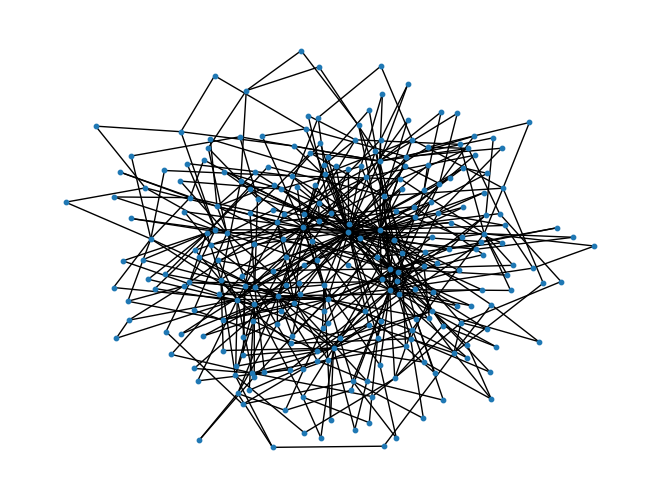

In [5]:
nx.draw(g,node_size=10)

## From the topology, we extract the information for the GNN including:
- Node features
- normalized partition curve(10 points in the curve)
- edge index

In [6]:
X = get_feature(g).float().to(device)
adj = torch.from_numpy(nx.to_numpy_array(g)).to(device)
y = get_zt(adj).float().to(device)
edge_index = torch_geometric.utils.dense_to_sparse(adj)[0].to(device)

/tmp/ipykernel_23428/3945386375.py:3: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/Copy.cpp:276.)
  y = get_zt(adj).float().to(device)


## Define the model and optimizer

In [7]:
macro_node = 30
encoder = Encoder(input_dim =5, hidden_dim = 128, output_dim = macro_node, n_layers = 1).to(device)
decoder = WeightSumDecoder(macro_node)
op = torch.optim.Adam(encoder.parameters(),lr=0.0001)

## Start Training!

In [8]:
# record the loss
lss_train = []
lss_ce = []

In [9]:
for e in tqdm(range(5000)):
    # Partition function evaluation
    group = encoder(X,edge_index)
    new_p = decoder(group,adj.float())
    yhat = get_zt(new_p)
    l0 = torch.mean(torch.abs(y-yhat))
    
    # Cross Entropy Loss exists to make nodes as seperate as possible, it will be helpful for training in most cases
    sgroup = shuffle_rows(group)
    l1 = mins_cross_entropy(sgroup,group)
    
    loss= l0+l1*0.001 # this weight should not be too large, you can try by yourself
    
    # backpropagation and gradient decent
    op.zero_grad()
    loss.backward()
    op.step()
    
    # recording
    lss_train.append(l0.item())
    lss_ce.append(l1.item())

100%|██████████| 5000/5000 [00:48<00:00, 102.57it/s]


## Visualize the loss curve

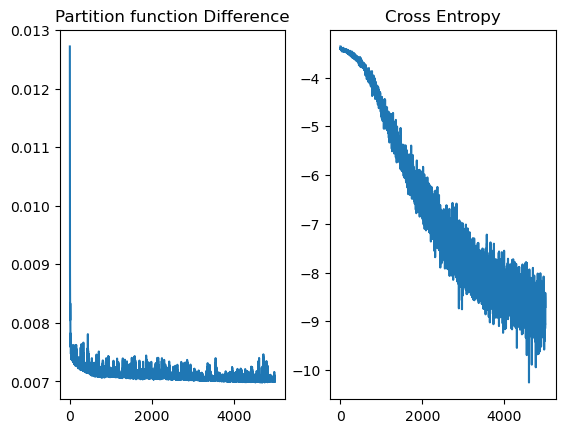

In [10]:
plt.subplot(121)
plt.title('Partition function Difference')
plt.plot(lss_train)
plt.subplot(122)
plt.title('Cross Entropy')
plt.plot(lss_ce)
plt.show()

## Visualize the Macro Network

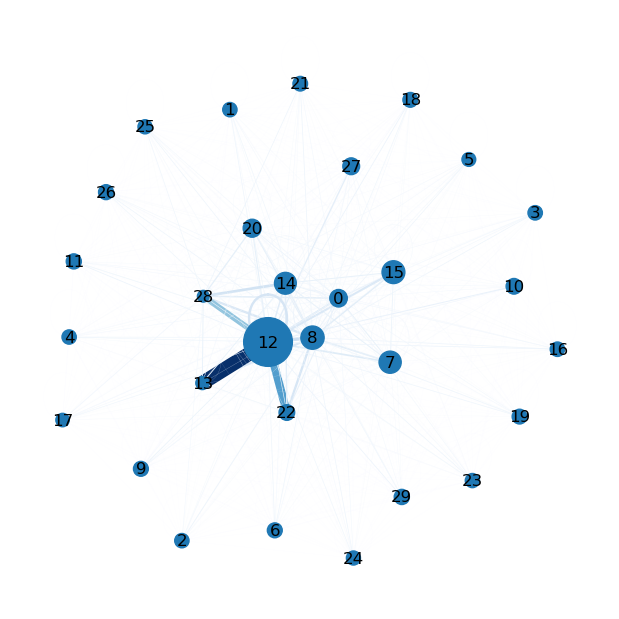

In [11]:
visualize_weighted_graph(new_p.cpu().detach().numpy(),np.sum(group.cpu().detach().numpy()*20,axis=0))

## And compare the partition function

/home/zhangzhang/anaconda3/envs/snn/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


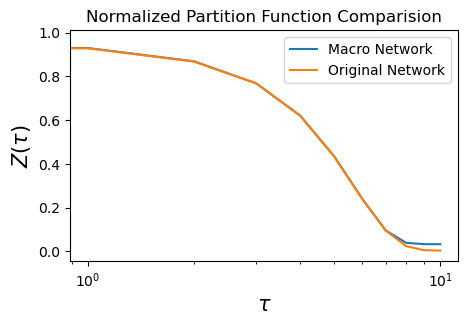

In [12]:
plt.figure(figsize=(5,3))
plt.title('Normalized Partition Function Comparision')
plt.plot(yhat.cpu().detach().numpy(),label='Macro Network')
plt.plot(y.cpu().detach().numpy(),label='Original Network')
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$Z(\tau)$',fontsize=15)
plt.xscale('log')
plt.legend()
plt.show()